In [1]:
import numpy as np  
import math
from enum import Enum
from collections import namedtuple

# matplotlib
# ライブラリーのインポート
import matplotlib.pyplot as plt
# インライン表示
%matplotlib inline
# 日本語フォント
import pylab
from matplotlib.font_manager import FontProperties

# 家電機器

## 14.　アイロン（ver自立P4）

### 14.1　定義

#### 14.1.1　機器の電源接続状態および動作状態

アイロンの電源接続状態および動作状態は、以下を想定する。

* 電源接続状態：
    * 使用時にのみAC電源に接続される。
    * 非使用時には電源から切断される。  
* 動作状態：
    * 使用時には稼働状態のみが発生する。
    * 非使用時には停止状態となる。  

#### 14.1.2　機器の機能等

アイロンが有する機能は、以下を想定する。  

* 機能：
    * アイロン：主機能である。稼働時に作動する。

想定する状態および機能に対応する添え字は以下のとおりである。なお、単機能であるため、機能に対応する添え字は省略する。  

| 添え字 | 電源接続状態 | 動作状態 |　機能　 | 
|:-----: |:-----------: |:-------: |:------: |    
|ac,opg  |AC電源接続    |稼働      |アイロン |  

In [2]:
# 電源接続状態
PowerSource = namedtuple ("PowerSource", "ac")
    # ac：AC電源接続

In [3]:
# 動作状態
AppStatus = namedtuple ("AppStatus", "opg")
    # opg：稼働

### 14.2　消費電力量

日付$d$の時刻$t$におけるアイロンのAC電源接続時の消費電力量$E_{E,Iron,ac,d,t}$は、式(1)により表される。

* AC電源接続時：  
$$ 
\begin{equation*}
    E_{E,Iron,ac,d,t} = E_{E,ac,opg,d,t} 
\end{equation*}
$$


<div style="text-align: right;"> (1) </div>

ここで、  

$E_{E,Iron,ac,d,t}$：日付$d$の時刻$t$におけるAC電源接続時の単位時間当たりの消費電力量[Wh]  
$E_{E,ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時の単位時間当たりの消費電力量[Wh]  

である。

In [4]:
def EE_ac (ee_ac):
    """AC電源接続時の消費電力量[Wh]を計算する""" 
    # ee_ac：AC電源接続下での消費電力量[Wh](リスト型)
    
    return sum(ee_ac)

### 14.3　稼働時の消費電力量

日付$d$の時刻$t$におけるAC電源接続下での稼働時の消費電力量は、式(2)により計算される。

* AC電源接続下での稼働時の消費電力量：  
$$ 
\begin{equation*}
    E_{E,ac,opg,d,t} = P_{opg} \times dt_{ac,opg,d,t} \div 3600
\end{equation*}
$$


<div style="text-align: right;"> (2) </div>

ただし、式(3)を満たす。
$$ 
\begin{equation*}
    dt_{ac,opg,d,t} \leq dt_{calc}
\end{equation*}
$$
<div style="text-align: right;"> (3) </div>

ここで、  

$dt_{calc}$：単位時間[s]   
$dt_{ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時間の合計[s]  
$E_{E,ac,opg,d,t}$：日付$d$の時刻$t$におけるAC電源接続下での稼働時の単位時間当たりの消費電力量[Wh]   
$P_{opg}$：1時間当たりの稼働時の平均消費電力[W] 

である。

In [5]:
def EE_ac_opg (dt_ac_opg, P_ac_opg):
    """AC電源接続下での稼働時の消費電力量[Wh]を計算する""" 
    # dt_ac_opg：稼働時間の合計[s](リスト型)
    # P_ac_opg：稼働時の消費電力[W](リスト型)
    
    p = np.array(dt_ac_opg)
    dt = np.array(P_ac_opg)
    
    return sum(p * dt) / 3600

In [6]:
def check_duration (dt):
    """合計が単位時間を超過しないか否かを確認する"""
    # dt：稼働時間の合計[s](PowerSource型(AppStatus型))
    
    # dt_calc：単位時間[s]
    dt_calc = 3600.
    
    # 継続時間を積算する
    dt_sum = 0
    for isource in range(0, len(dt)):
        for istatus in range(0, len(dt[isource])):
            dt_sum = dt_sum + dt[isource][isource]
    
    # エラーチェック
    if dt_calc < dt_sum:
        # 単位時間を超える場合 => エラー
        try:
            raise ValueError("Error: dt_calc < sum(dt)")
        except ValueError as e:
            print(e)
    else:
        pass

日付$d$の時刻$t$における稼働時の消費電力は、式(4)により計算される。

* 稼働時の消費電力： 
$$ 
\begin{equation*}
    P_{opg} = 0.53 \times P_{rtd,opg} 
\end{equation*}
$$


<div style="text-align: right;"> (4) </div>

ここで、   

$P_{opg}$：1時間当たりの稼働時の平均消費電力[W]  
$P_{rtd,opg}$：定格消費電力[W]  

である。

In [7]:
def P_opg (Prtd_opg):
    """稼働時の消費電力[W]を計算する""" 
    # Prtd_opg：稼働時の消費電力[W]
    
    return 0.53 * Prtd_opg

### 14.4　標準条件

#### 14.4.1　機器仕様

4人世帯の標準的な機器仕様として、下表の設定を用いることができる。

| 番号 | 稼働時の定格消費電力[W] |            備考             |
|:---: | :---------------------: | :-------------------------: |
|  00  | 1400       　　　　     | 4人標準世帯のデフォルト設定 |

In [8]:
Spec = {'Iron00':{'Prtd_opg':1400}}

#### 14.4.2　機器使用スケジュール

4人世帯の標準的なスケジュールとして、下表の設定を用いることができる。

| 番号 | スケジュール名称 | 備考 |
|:---: | :--------------: | :--: |
|  00  | 4人標準世帯      | -    |

* 平日：  

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

* 休日在宅： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  6|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 54| 60| 60| 60| 60| 60| 60| 60| 

* 休日外出： 

|時刻                  |0  |1  |2  |3  |4  |5  |6  |7  |8  |9  |10 |11 |12 |13 |14 |15 |16 |17 |18 |19 |20 |21 |22 |23 |  
|:---:                 | -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:| -:|  
|AC稼働時間[\* 60 s]   |  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  
|電源切断時間[\* 60 s] | 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 60| 

In [9]:
# 機器使用スケジュール：4人標準世帯_AC接続下での稼働時間[s]
schd_ac_opg_4p_std = { 'Weekdays'    : [0]* 9 + [360]*1 + [0]*14,  
                       'Holidays_st' : [0]*16 + [360]*1 + [0]* 7, 
                       'Holidays_go' : [0]*24
                     }

In [10]:
def plot_hourly_bar_chart(fig_title, y_value_set, y_value_set_name_p, y_value_set_names_s, category_labels, 
                          y_label, y_lower, y_upper, y_interval, y_convert_unit):
    '''横軸が時刻（1時間間隔、0～23時間）の棒グラフを作成する'''
    # fig_title：図のタイトル
    # y_value_set：y軸の値
    # y_value_set_name_p：y軸の値のデータセット名（主）
    # y_value_set_names_s：y軸の値のデータセット名（副）
    # category_labels：カテゴリーのラベル
    # y_label：y軸のラベル
    # y_lower：y軸の表示の下限
    # y_ upper：y軸の表示の上限
    # y_ interval：y軸の目盛間隔
    # y_convert_unit：y軸の単位換算係数

    # 日本語フォント
    fp = FontProperties(fname='C:\WINDOWS\Fonts\msgothic.ttc', size = 12)
    
    # 既存スタイルの使用
    plt.style.use('seaborn-whitegrid')

    # サブプロットの作成
    plt.figure(figsize=(12, 3), dpi=80)

    for iplotw, y_value_set_name_s in enumerate(y_value_set_names_s):
        # サブプロットの指定
        ax = plt.subplot2grid((1, len(y_value_set_names_s)), (0, iplotw))

        # 棒グラフの作成
        # x軸の値
        x_value = np.array([k for k in range(24)])
        # y軸の値
        y_value = np.array(y_value_set[y_value_set_name_s]) * y_convert_unit
        if len(y_value) > 0:
            ax.bar(x_value, y_value, align='edge', width=1.0, edgecolor='black', label=category_labels[0])

        # グラフのタイトル
        ax.set_title(y_value_set_name_p +'(' + y_value_set_name_s + ')' , fontdict={'fontproperties':fp})

        # x軸
        # タイトル
        ax.set_xlabel(u'時刻', fontdict={'fontproperties':fp})
        # 目盛りの位置／ラベル／形式
        # 主目盛
        ax.set_xticks(np.arange(0, 25, 3), minor=False)
        ax.set_xticklabels(np.array([k*3 for k in range(8)]+[0]).astype('str'), minor=False, visible=True)
        ax.tick_params(axis='x', which ='major', direction='in', length=3)
        # 補助目盛
        ax.set_xticks(np.arange(0, 25, 1), minor=True)
        ax.set_xticklabels(np.array([k for k in range(24)]+[0]).astype('str'), minor=True, visible=False)
        ax.tick_params(axis='x', which ='minor', direction='in', length=3)
        # 表示の上限・下限
        ax.set_xbound(lower=0, upper=24)

        # y軸
        #タイトル
        ax.set_ylabel(y_label, fontdict={'fontproperties':fp}) 
        # 目盛りの位置／形式
        #ax.set_yticks(np.arange(0, 30, 5))
        ax.set_yticks(np.arange(y_lower, y_upper+y_interval, y_interval))
        ax.tick_params(axis='y', which ='major', direction='in', length=3)
        # 表示の上限・下限
        ax.set_ybound(lower=y_lower, upper=y_upper)

        # グラフの枠
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')

        # 主目盛りのグリッド
        ax.grid(which='major', color='lightgray', alpha=0.7, linestyle='-')
            
    # グラフの重なりを解消
    plt.tight_layout()

    # 凡例
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.5, frameon=True,  prop=fp)

    plt.show()

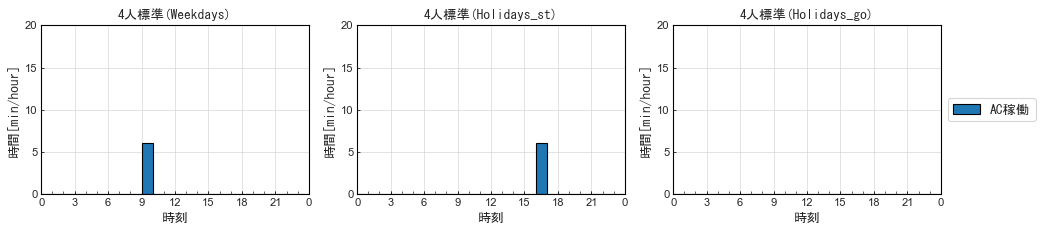

In [11]:
# 機器使用スケジュールの確認
plot_hourly_bar_chart('使用スケジュール', 
                      schd_ac_opg_4p_std, 
                      '4人標準',
                      ['Weekdays', 'Holidays_st', 'Holidays_go'], 
                      ['AC稼働'],
                       "時間[min/hour]",  0, 20, 5, 1/60)

### 付録1：サンプルコード

4人標準世帯の標準条件について、サンプルコードを示す。

In [12]:
def get_spec(Spec, app_type):
    '''機器仕様を取得する'''
    # Spec：
    # app_type：機器タイプ
    
    # 機器仕様の取得
    try:
        spec = Spec[app_type]
    except:
        raise
    
    return spec

In [13]:
def get_dt(time_use_type, time_of_day, schd_number):
    """機器使用スケジュールを取得する"""
    # time_use_type：0=平日、1=休日在宅、2=休日外出
    # time_of_day：時刻[-]
    # schd_number：スケジュールの番号（0～）
     
    schedulename = {
        0 : 'weekdays',
        1 : 'holidays_st',
        2 : 'holidays_go'
    }[time_use_type]

    # スケジュールの取得
    if  schd_number <= len(schd_list) :
        schd = schd_list[schd_number]
    else:
        schd = schd_list[0]

    # 当該単位時間において各動作状態が維持される時間[s]の取得
    for isource in range(0, len(schd)):
        schd_set_list = schd[isource]
        dt_status = []
        for istatus in range(0, len(schd_set_list)):
            schd_set_list_source = schd_set_list[istatus]
            dt_status = dt_status + [schd_set_list_source[schedulename][time_of_day]]
        # AC電源接続時に単位時間において各動作状態が維持される時間の合計[s]
        dt_ac = AppStatus._make(dt_status)
        
    # 単位時間において各動作状態が維持される時間の合計[s]
    dt = PowerSource(ac = dt_ac)

    # 時間超過の確認
    check_duration(dt) 
    
    return dt

In [14]:
def calc_EE_ac_opg(dt, app):
    """AC電源接続下の稼働時における消費電力量[Wh]を計算する"""
    # dt：単位時間における継続時間の合計[s](PowerSource型(AppStatus型))
    # app：機器の仕様[-](AppSpec型)
    
    # AC電源接続時の単位時間における継続時間の合計[s]
    dt_ac_opg = dt.ac.opg
    
    # AC電源接続時の消費電力[W]
    p_ac_opg = P_opg(app['Prtd_opg'])
    
    # AC電源接続時の消費電力量[Wh]
    ee_ac_opg = EE_ac_opg([dt_ac_opg], [p_ac_opg])
    
    return ee_ac_opg

In [15]:
def calc_EE_Iron_verP4(time_use_type, time_of_day, app_type, schd_number):
    """アイロンの単位時間当たりの消費電力量を計算する（ver自立P4）"""
    # time_use_type：0=平日、1=休日在宅、2=休日外出
    # time_of_day：時刻（0-23） 
    # app_number：機器の番号（0～）  
    # schd_number：スケジュールの番号（0～） 
    
    # 機器使用スケジュール[s]を取得
    dt = get_dt(time_use_type, time_of_day, schd_number)
    
    # 機器仕様を取得
    app = get_spec(Spec, app_type)
    
    # AC電源接続下の稼働時における消費電力量[Wh]を計算
    ee_ac_opg = calc_EE_ac_opg(dt, app)
    
    # AC電源接続時における消費電力量[Wh]を計算
    ee_ac = EE_ac ([ee_ac_opg])
    
    return ee_ac, ee_ac_opg

4人標準世帯の標準条件に対して、サンプルコードにより平日、休日在宅、休日外出の時刻別消費電力量を計算した結果を示す。

In [16]:
# 消費電力量の計算
calc_EE = np.vectorize(calc_EE_Iron_verP4)(np.array([[0], [1], [2]]), np.array([np.arange(24)]*3), 'Iron00', 0)

NameError: name 'schd_list' is not defined

In [ ]:
# 消費電力量の計算結果
result = AppStatus(opg = TimeUseType (weekdays = calc_EE[1][0], holidays_st = calc_EE[1][1], holidays_go = calc_EE[1][2]))
EE = PowerSource(ac = result)

In [ ]:
EE

In [ ]:
# 消費電力量の計算結果のグラフ
draw_hourly_bar_chart(EE, '4人標準', ["平日", "休日在宅", "休日外出"], ["AC稼働"], "消費電力量[Wh/h]", 0, 100, 20, 1)